In [27]:
import numpy as np
import tensorflow as tf

2023-04-22 16:32:20.921311: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


transformers can do bayesian inference paper

In [33]:
import random
import math
from PIL import Image, ImageDraw, ImageFilter

In [34]:
def pencil_stroke_prior(num_classes=2, size=28, min_max_strokes=(1,3), 
                        min_max_len =(5/28 ,20/28) , min_max_start =(2/28 ,25/28),
                        min_max_width=(1/28,4/28),max_offset=4/28, 
                        max_target_offset=2/28):
    classes = []

    for i in range ( num_classes ):
        num_strokes = random.randint (* min_max_strokes ) 
        len_strokes = [random.randint(int(size * min_max_len[0]),
                                      int ( size * min_max_len [1])) for i in range ( num_strokes )] 
        stroke_start_points = [
            (random.randint(int(size * min_max_start[0]), int(size * min_max_start[1])), random.randint(int(size * min_max_start[0]), int(size * min_max_start[1]))) for i in
            range(num_strokes)]
        stroke_directions = []
        for i in range(num_strokes):
            sp, length = stroke_start_points[i], len_strokes[i]
            counter = 0
            while True:
                if counter % 3 == 0:
                    length = random.randint(int(size * min_max_len[0]), int(size * min_max_len[1]))
                    sp = (
                    random.randint(int(size * min_max_start[0]), int(size * min_max_start[1])), random.randint(int(size * min_max_start[0]), int(size * min_max_start[1])))
                    stroke_start_points[i], len_strokes[i] = sp, length
                radians = random.random() * 2 * math.pi
                x_vel = math.cos(radians) * length
                y_vel = math.sin(radians) * length
                new_p = (sp[0] + x_vel, sp[1] + y_vel)
                # print(math.degrees(radians),sp,new_p)
                if not any(n > size - 1 or n < 0 for n in new_p):
                    break
                counter += 1
            stroke_directions.append(radians)
            # print([round(x) for x in sp+new_p])
            # draw.line([round(x) for x in sp+new_p], fill=128, width=3)
        classes.append((len_strokes, stroke_start_points, stroke_directions))
        
    generator_functions = []
    for c in classes:
        def g(c=c):
            len_strokes, stroke_start_points, stroke_directions = c
            i = Image.fromarray(np.zeros((size, size), dtype=np.uint8))
            draw = ImageDraw.Draw(i)
            width = random.randint(int(size * min_max_width[0]), int(size * min_max_width[1]))
            offset = random.randint(int(-size * max_offset), int(size * max_offset)), random.randint(int(- size * max_offset), int(size * max_offset))
            for sp, length, radians in zip(stroke_start_points, len_strokes, stroke_directions):
                sp = (sp[0] + offset[0], sp[1] + offset[1])
                x_vel = math.cos(radians) * length + random.randint(int(-size * max_target_offset), int(size * max_target_offset))
                y_vel = math.sin(radians) * length + random.randint(int(-size * max_target_offset), int(size * max_target_offset))
                new_p = (sp[0] + x_vel, sp[1] + y_vel)
                stroke_directions.append(radians)
                draw.line([round(x) for x in sp + new_p], fill=128, width=width)
            a_i = np.array(i)
            a_i[a_i == 128] = np.random.randint(200, 255, size=a_i.shape)[a_i == 128]
            return Image.fromarray(a_i).filter(ImageFilter.GaussianBlur(.2))

        generator_functions.append(g)
        
    return generator_functions

In [30]:
pencil_stroke_prior(num_classes=2, size=28, min_max_strokes=(1,3), 
                        min_max_len =(5/28 ,20/28) , min_max_start =(2/28 ,25/28),
                        min_max_width=(1/28,4/28),max_offset=4/28, 
                        max_target_offset=2/28)

[<function __main__.pencil_stroke_prior.<locals>.g(c=([6], [(22, 16)], [2.272083513864907]))>,
 <function __main__.pencil_stroke_prior.<locals>.g(c=([5, 13, 16], [(4, 23), (10, 18), (20, 12)], [0.2545521205068265, 6.197933196179025, 2.7879733122803136]))>]

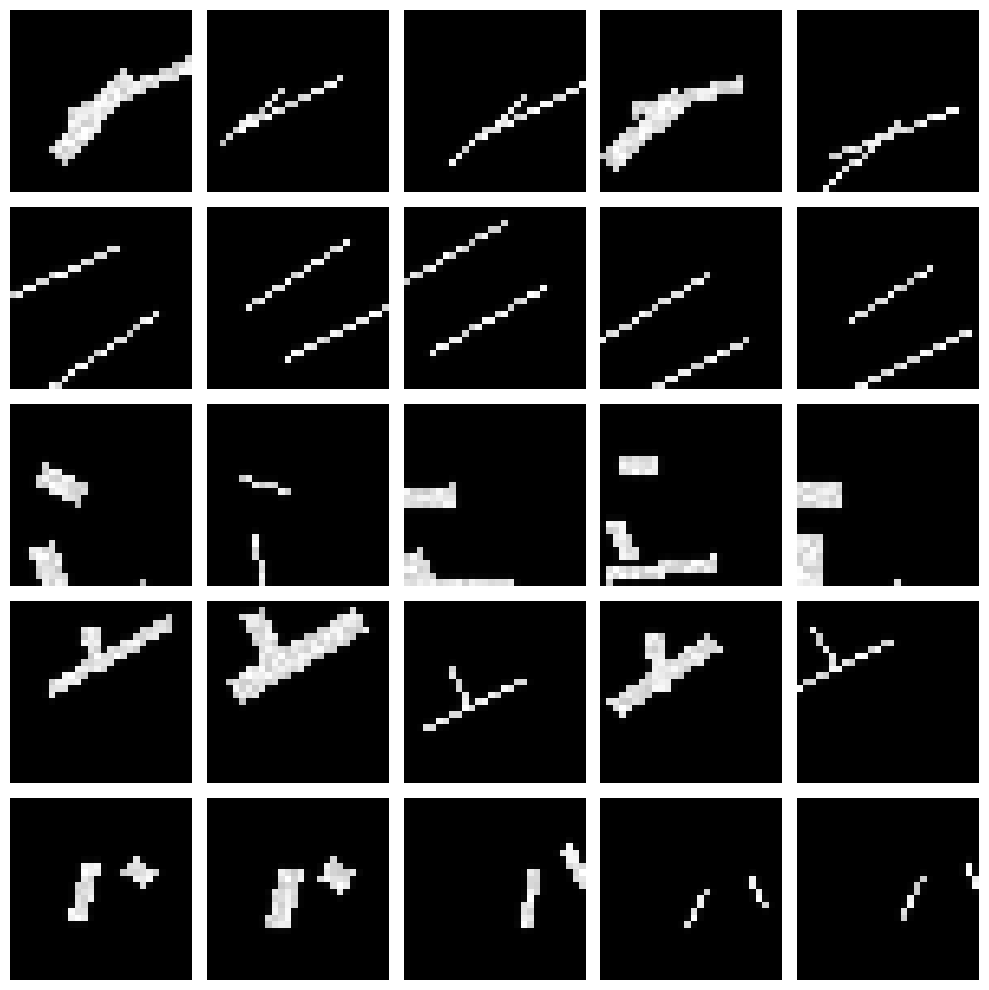

In [38]:
num_classes = 5
num_samples=5

fig, axs = plt.subplots(num_classes, num_samples, figsize=(10, 10))

generator_functions= pencil_stroke_prior(num_classes, size=28, min_max_strokes=(1,3), 
                        min_max_len =(5/28 ,20/28) , min_max_start =(2/28 ,25/28),
                        min_max_width=(1/28,4/28),max_offset=4/28, 
                        max_target_offset=2/28)

for i in range(num_classes):
    for j in range(num_samples):
        axs[i, j].imshow(generator_functions[i](), cmap='gray')
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()